In [70]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
#from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore');
plt.rcParams.update({'figure.max_open_warning': 0})
import scipy.stats as stats
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join
from tqdm import tqdm
#from bisect import bisect_left
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
plt.rcParams.update({'font.size': 18})
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
plt.rcParams['figure.figsize'] = [7, 5]
#from IPython.display import Audio, display
#def allDone():
#    display(Audio(filename='beep.mp3', autoplay=True))
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
#import lmfit

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
#import emcee
import corner
#import numdifftools
from scipy.ndimage import interpolation
from scipy.signal import medfilt
from scipy.interpolate import interp1d
#from multiprocessing import Pool
#import pickle
#import h5py
#import multiprocessing
#import itertools
#from multiprocessing import sharedctypes
print('imported')
import scipy
import pickle

imported


In [2]:
import pandas as pd

In [3]:
import keras.backend as K

Using TensorFlow backend.


In [4]:
import tensorflow as tf

In [5]:
from keras.models import Sequential,Model
from keras.layers import Dense,Input
from keras.optimizers import Adam, Adamax, SGD
#from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,scale,MinMaxScaler,StandardScaler

In [6]:
## Enter parameter:
searchparameter = '_'

prefilenames = os.listdir('koester2/')
filenames = []
for i in range(len(prefilenames)):
    if searchparameter in prefilenames[i]:
        filenames.append(prefilenames[i])
        
len(filenames)

1040

In [7]:
modelspectra = [];
modelwl = [];
loggs = [];
teffs = [];
for i in tqdm(filenames):
    specname=i
    f = open('koester2/'+specname)
    data = f.readlines()
    f.close()
    headerdata = data[0:7]
    spectraldata = data[6:]
    lam = []
    flux = []

    for i in range(len(spectraldata)):
        l=float(spectraldata[i].split()[0])
        lam.append(l)
        f = float(spectraldata[i].split()[1])
        flux.append(f)

    lam = np.asarray(lam)
    flux = np.asarray(flux) / 1e7

    teff = float(headerdata[1].split()[3])
    logg = float(headerdata[2].split()[3])
    
    in1 = find_nearest(lam,4000)
    in2 = find_nearest(lam,8000)

    flux = flux[in1:in2]
    lam = lam[in1:in2]
    
    flux = flux[:-1][~ (np.diff(lam) == 0)]
    lam = lam[:-1][~ (np.diff(lam) == 0)]
    
    lamgrid = np.arange(4000,8000)
    
    func = interp1d(lam,flux,kind='linear',assume_sorted = False,fill_value='extrapolate')
    flux = func(lamgrid)
    
    modelspectra.append(flux)
    modelwl.append(lam)
    teffs.append(teff)
    loggs.append(logg)

modelspectra = np.asarray(modelspectra)
loggs = np.asarray(loggs)
teffs = np.asarray(teffs)

100%|██████████| 1040/1040 [00:07<00:00, 145.39it/s]


In [8]:
X = np.stack((teffs,loggs)).transpose()
t = np.log(modelspectra)

sc = MinMaxScaler()
msc = StandardScaler()

X_scaled = sc.fit_transform(X)
t_scaled = msc.fit_transform(t)

pickle.dump(sc,open('koesterddsc.p','wb'))
pickle.dump(msc,open('koesterddmsc.p','wb'))

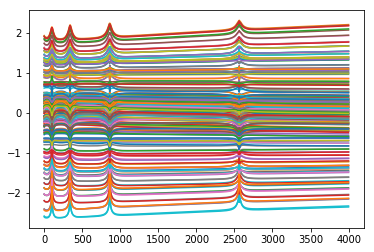

In [9]:
plt.plot(t_scaled[0:205].T);

In [11]:
H = 128
def generator():
    x = Input(shape=(X[0].shape[0],))
    y = Dense(H,activation='sigmoid')(x)
    y = Dense(H,activation='sigmoid')(y)
    y = Dense(H,activation='sigmoid')(y)
    y = Dense(H,activation='sigmoid')(y)
    out = Dense(4000,activation='linear')(y)
    
    model = Model(inputs = x, outputs = out)
    model.compile(optimizer = Adamax(), loss = 'mse', \
                  metrics = ['mae'])
    return model
model = generator()
history = [];
model.load_weights('model_interp_deep.h5')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 4000)              516000    
Total params: 565,920
Trainable params: 565,920
Non-trainable params: 0
_________________________________________________________________
None

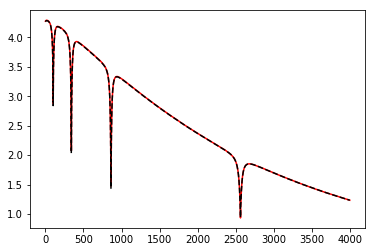

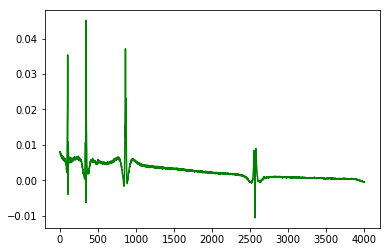

In [13]:
n = np.random.randint(0,len(X))
label = X_scaled[n].reshape(1,-1)
true = np.exp(t[n])
pred = np.exp(msc.inverse_transform(model.predict(label)))[0,:]
plt.plot(true,'k--',zorder=8)
plt.plot(pred,'r-')
plt.figure()
plt.plot(pred-true,'g-')

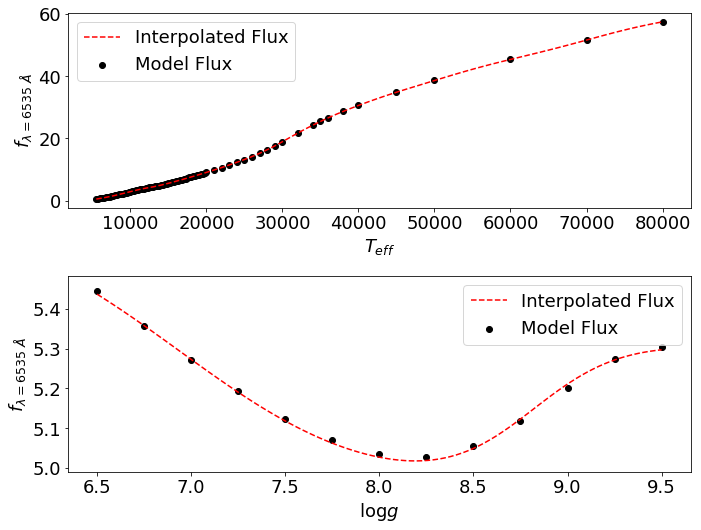

In [144]:
pixel = 2535
temp = 14000

plt.figure(figsize=(10,7))
plt.subplot(211)

ts = teffs[loggs == 8]
ls = loggs[loggs == 8]
labels = np.stack((ts,ls)).T
tflux = np.exp(t)[loggs == 8][:,pixel]

plt.scatter(ts,tflux,color='k',label = 'Model Flux')

linls = np.repeat(8.,100)
lints = np.linspace(min(ts),max(ts),100)
linlabels = np.stack((lints,linls)).T
lintflux = np.exp(msc.inverse_transform(model.predict(sc.transform(linlabels))))[:,pixel]
plt.plot(lints,lintflux,'r--',label = 'Interpolated Flux')
plt.ylabel('$f_{\lambda = %i \ \AA}$'%(pixel+4000))
plt.xlabel('$T_{eff}$')
plt.legend()
plt.tight_layout()

plt.subplot(212)
ts = teffs[teffs == temp]
ls = loggs[teffs == temp]
labels = np.stack((ts,ls)).T
tflux = np.exp(t)[teffs == temp][:,pixel]

plt.scatter(ls,tflux,color='k',label = 'Model Flux')

linls = np.linspace(min(ls),max(ls),100)
lints = np.repeat(temp,100)
linlabels = np.stack((lints,linls)).T
lintflux = np.exp(msc.inverse_transform(model.predict(sc.transform(linlabels))))[:,pixel]
plt.plot(linls,lintflux,'r--',label = 'Interpolated Flux')
plt.ylabel('$f_{\lambda = %i \ \AA}$'%(pixel+4000))
plt.xlabel('$\log{g}$')
plt.legend()



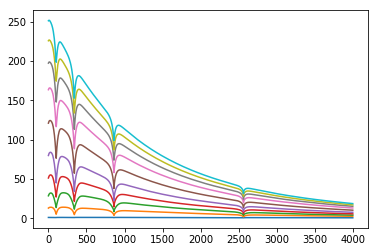

In [15]:
n = 10
ls = np.linspace(8,8,n)
ts = np.linspace(6000,50000,n)
labels = np.stack((ts,ls)).T
preds = np.exp(msc.inverse_transform(model.predict(sc.transform(labels))))
for i in preds:
    plt.plot(i)

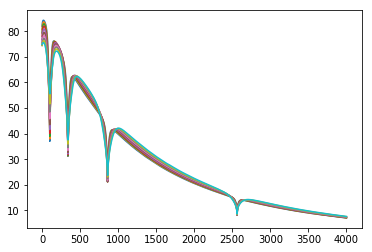

In [17]:
n = 10
ls = np.linspace(6.5,9.5,n)
ts = np.linspace(25000,25000,n)
labels = np.stack((ts,ls)).T
preds = np.exp(msc.inverse_transform(model.predict(sc.transform(labels))))
for i in preds:
    plt.plot(i)

In [35]:
preds = np.exp(msc.inverse_transform(model.predict(sc.transform(X))))
truths = np.exp(t)

In [37]:
np.sqrt(np.mean(preds - truths)**2)

0.0011133905148890645

In [42]:
np.mean(np.abs(100* (preds - truths) / truths))

0.07244107684953573

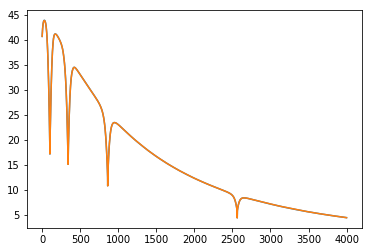

In [33]:
plt.plot(truths[23])
plt.plot(preds[23])

## Adaptive Continuum Determination

In [44]:
def ch_cont(array):
    spec = array
    lamgrid = np.linspace(4000,8000,4000)
    p = np.polynomial.chebyshev.chebfit(lamgrid,spec,5)
    contcorr = spec / np.polynomial.chebyshev.chebval(lamgrid,p)
    return contcorr

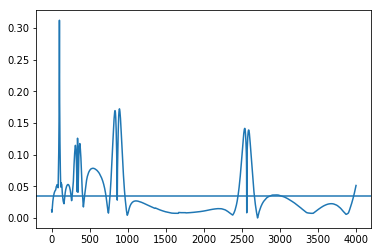

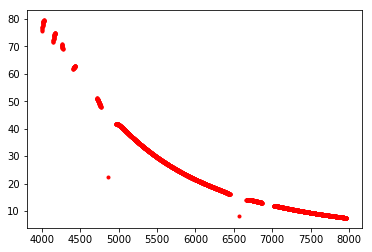

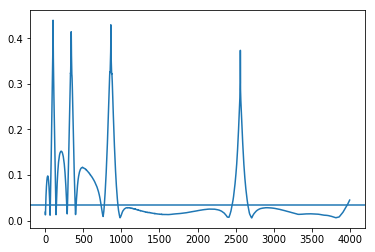

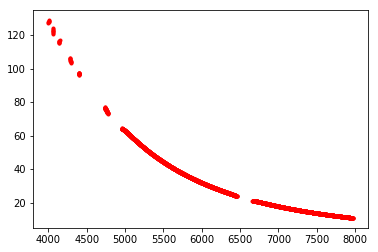

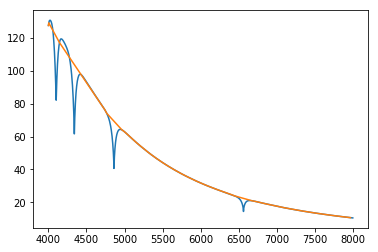

In [67]:
ii = 5


n = 10
ls = np.linspace(6.5,9.5,n)
ts = np.linspace(25000,25000,n)

labels = np.stack((ts,ls)).T
preds = np.exp(msc.inverse_transform(model.predict(sc.transform(labels))))

cpreds = [];
diffs = np.repeat(0,4000)
for i in range(len(preds)):
    cpreds.append(ch_cont(preds[i]))
cpreds = np.asarray(cpreds)

thresh = 0.035

plt.plot(np.ptp(cpreds,0))
plt.axhline(thresh)
contbool = (np.ptp(cpreds,0) < thresh)
plt.figure()
plt.plot(lamgrid[contbool],preds[ii][contbool],'r.')

n = 10
ls = np.linspace(8.,8.,n)
ts = np.linspace(7500,50000,n)

labels = np.stack((ts,ls)).T
preds = np.exp(msc.inverse_transform(model.predict(sc.transform(labels))))

cpreds = [];
for i in range(len(preds)):
    cpreds.append(ch_cont(preds[i]))
cpreds = np.asarray(cpreds)

thresh = 0.035

plt.figure()
plt.plot(np.ptp(cpreds,0))
plt.axhline(thresh)
teffcontbool = (np.ptp(cpreds,0) < thresh)
plt.figure()
plt.plot(lamgrid[teffcontbool],preds[ii][teffcontbool],'r.')

continuum = (teffcontbool * contbool)
plt.figure()
plt.plot(lamgrid,preds[ii])
plt.plot(lamgrid[continuum],preds[ii][continuum])

Text(0.5, 52.00000000000007, 'Wavelength ($\\AA$)')

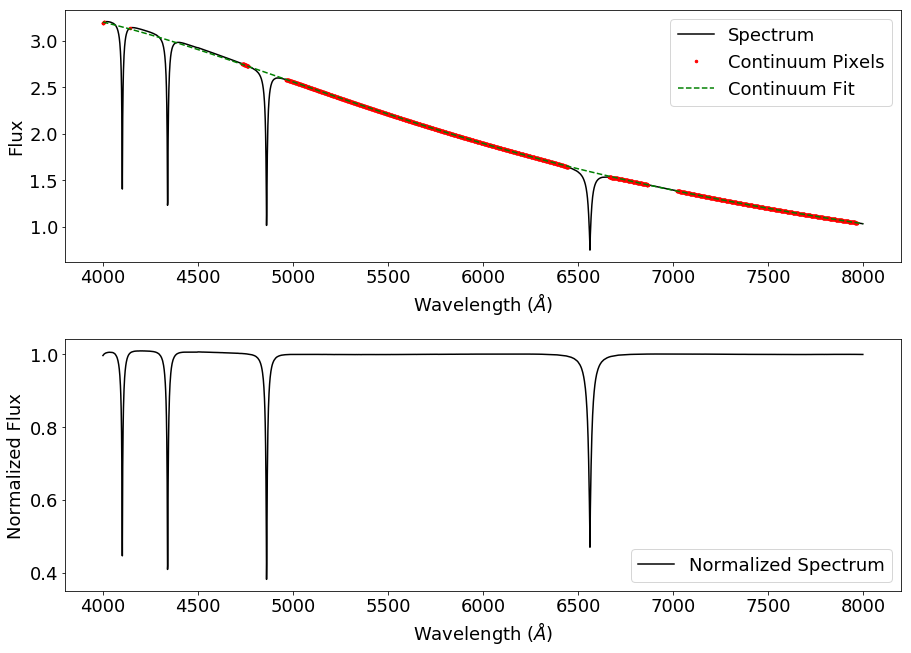

In [101]:
plt.figure(figsize = (13,9))

spec = preds[0]

plt.subplot(211)
plt.plot(lamgrid,spec,'k',label='Spectrum')
plt.plot(lamgrid[continuum],spec[continuum],'r.',markersize=5,label = 'Continuum Pixels')
p = np.polynomial.chebyshev.chebfit(lamgrid[continuum],spec[continuum],5)
contcorr = spec / np.polynomial.chebyshev.chebval(lamgrid,p)
plt.plot(lamgrid,np.polynomial.chebyshev.chebval(lamgrid,p),'g--',label = 'Continuum Fit')
plt.ylabel('Flux')
plt.xlabel('Wavelength ($\AA$)')
plt.legend()
plt.subplot(212)
plt.plot(lamgrid,contcorr,'k',label = 'Normalized Spectrum')
plt.legend()
plt.tight_layout()
plt.ylabel('Normalized Flux')
plt.xlabel('Wavelength ($\AA$)')

In [99]:
import pickle
pickle.dump(continuum,open('continuumwls.p','wb'))

In [72]:
def adapted_ch_cont(array,continuum):
    spec = array
    lamgrid = np.linspace(4000,8000,4000)
    p = np.polynomial.chebyshev.chebfit(lamgrid[continuum],spec[continuum],5)
    contcorr = spec / np.polynomial.chebyshev.chebval(lamgrid,p)
    return contcorr

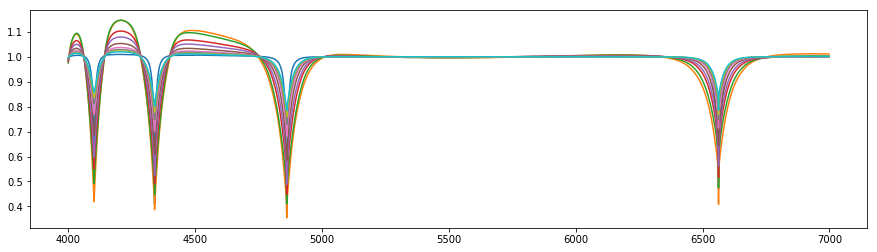

In [133]:
plt.figure(figsize=(15,4))
for ii in range(10):
    plt.plot(lamgrid[0:3000],adapted_ch_cont(preds[ii],continuum)[0:3000])

In [43]:
%%timeit
adapted_ch_cont(preds[ii],continuum)

NameError: name 'adapted_ch_cont' is not defined